In [ ]:
# q_true = E[R_t | A_t = a] where E is the expected value of the reward R_t given the action A_t = a

# q_estimate = sum of rewards when a taken prior to t / number of times a taken prior to t
# Sigma_i=1^(t-1) R_i * 1(A_i = a) / Sigma_i=1^(t-1) 1(A_i = a) where 1(A_i = a) is the predicate that is 1 if A_i = a and 0 otherwise
# This is called the sample-average method

# Greedy action selection
# A_t = argmax_a Q_t(a) where Q_t(a) is the estimated value of action a at time t

# Learning method - temporal difference learning
# V(s_t) = V(s_t) + alpha * (V(s_t+1) - V(s_t)) where V(s_t) is the estimated value of the state s_t and alpha is the step-size parameter

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(37)

# This was a set of 2000 randomly generated k-armed bandit problems with k = 10. For each bandit problem,
num_sets = 2000
num_steps = 1000
num_arms = 10

In [6]:
# the action values, q_*(a), a = 1, . . . , 10, were selected according to a normal (Gaussian) distribution with mean 0 and variance 1.
q_true = np.random.normal(0, 1, num_arms)
# Then, when a learning method applied to that problem selected action A_t at time step t, the actual reward, R_t, was selected from a normal distribution with mean q_*(A_t) and
# variance 1
R_true = np.random.normal(q_true, 1)

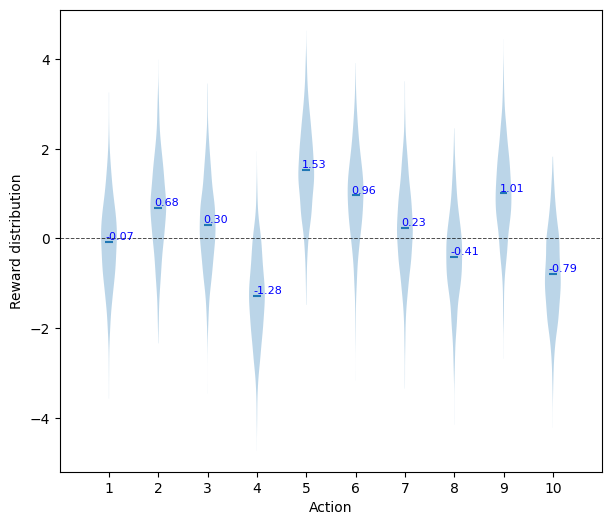

In [7]:
# Plot action vs reward distribution using matplotlib

fig, ax = plt.subplots(figsize=(7, 6))
np.random.seed(37)
D = np.random.normal(q_true, (1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00), (1000, 10))
vp = ax.violinplot(D, widths=0.32, showmeans=True, showmedians=False, showextrema=False)
ax.set(xlim=(0, 11), xticks=np.arange(1, 11))
ax.set_xticklabels([f'{i}' for i in range(1, 11)])
ax.set_xlabel('Action')
ax.set_ylabel('Reward distribution')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=0.7)
# Label the means of each violin plot
for i, mean_line in enumerate(vp['cmeans'].get_segments()):
    x = mean_line[0][0]
    y = mean_line[0][1]
    ax.text(x, y, f"{y:.2f}", ha='left', va='bottom', fontsize=8, color='blue')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(37)

# Standard 10-armed bandit testbed (Sutton & Barto):
# - 2000 independent bandit problems
# - 1000 time steps per problem
# - q*(a) ~ N(0, 1) fixed per problem; rewards R_t ~ N(q*(A_t), 1)
# - epsilon-greedy with sample-average updates
# - report average reward per step and % optimal action over time

num_sets = 2000
num_steps = 1000
num_arms = 10
epsilons = [0.0, 0.1, 0.01]

avg_rewards = {e: np.zeros(num_steps, dtype=float) for e in epsilons}
optimal_action_pct = {e: np.zeros(num_steps, dtype=float) for e in epsilons}

for epsilon in epsilons:
    for s in range(num_sets):
        q_star = np.random.normal(0.0, 1.0, size=num_arms)
        optimal_a = int(np.argmax(q_star))

        Q = np.zeros(num_arms, dtype=float)
        N = np.zeros(num_arms, dtype=int)

        for t in range(num_steps):
            # epsilon-greedy with random tie-breaking
            if np.random.rand() < epsilon:
                a = np.random.randint(num_arms)
            else:
                max_q = np.max(Q)
                ties = np.flatnonzero(Q == max_q)
                a = int(np.random.choice(ties))

            # sample reward and update sample-average estimate immediately
            r = np.random.normal(q_star[a], 1.0)
            N[a] += 1
            Q[a] += (r - Q[a]) / N[a]

            # accumulate metrics
            avg_rewards[epsilon][t] += r
            if a == optimal_a:
                optimal_action_pct[epsilon][t] += 1

    # average over problems
    avg_rewards[epsilon] /= num_sets
    optimal_action_pct[epsilon] = 100.0 * optimal_action_pct[epsilon] / num_sets

# Plot average reward
plt.figure(figsize=(14, 5))
for e in epsilons:
    plt.plot(avg_rewards[e], label=f"ε={e}")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()

# Plot % optimal action
plt.figure(figsize=(14, 5))
for e in epsilons:
    plt.plot(optimal_action_pct[e], label=f"ε={e}")
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.legend()
plt.show()

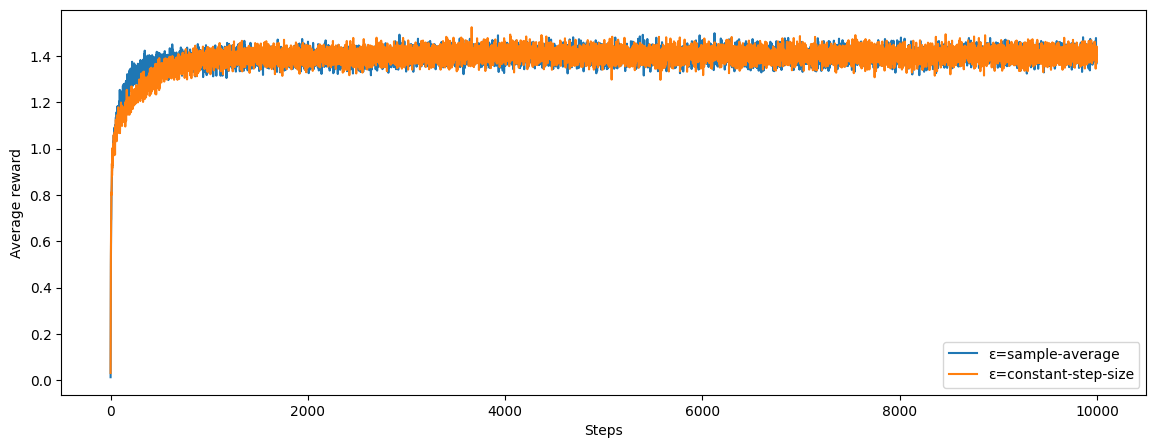

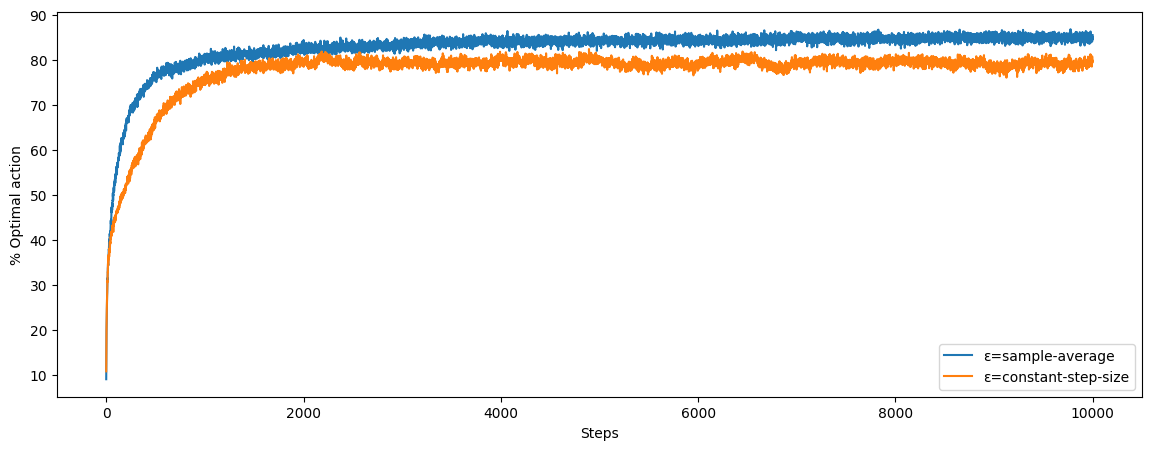

In [ ]:
import matplotlib.pyplot as plt
import asyncio
import concurrent.futures
from bandit_problem import  process_bandit_problem_nonstationary
from functools import partial

async def main():
    loop = asyncio.get_running_loop()

    with concurrent.futures.ProcessPoolExecutor() as pool:
        tasks = [
            loop.run_in_executor(pool, partial(process_bandit_problem_nonstationary, num_steps=10000, av_method=avm)) for avm in ['sample-average', 'constant-step-size']
        ]
        # Wait for all of them to finish
        results = await asyncio.gather(*tasks)

    # Plot average reward
    plt.figure(figsize=(14, 5))
    for result in results:
        plt.plot(result[1], label=f"ε={result[0]}")
    plt.xlabel("Steps")
    plt.ylabel("Average reward")
    plt.legend()
    plt.show()

    # Plot % optimal action
    plt.figure(figsize=(14, 5))
    for result in results:
        plt.plot(result[2], label=f"ε={result[0]}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal action")
    plt.legend()
    plt.show()

# ✅ Works in Jupyter:
await main()


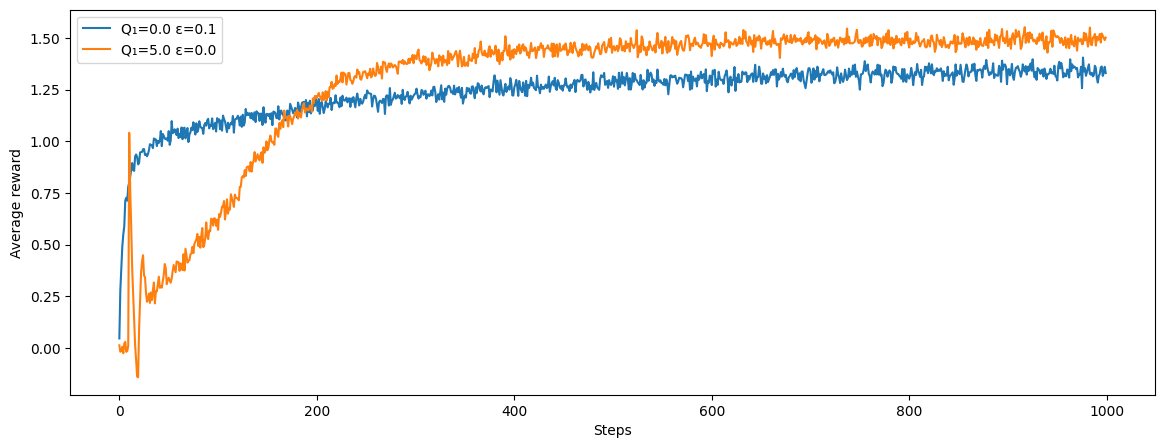

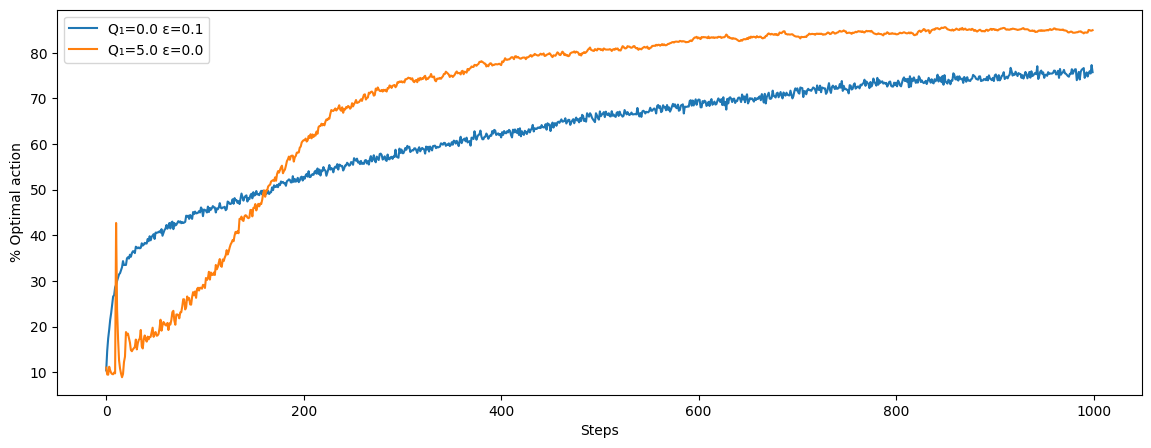

In [4]:
import matplotlib.pyplot as plt
import asyncio
import concurrent.futures
from bandit_problem import  process_bandit_problem_action_values
from functools import partial

async def main():
    loop = asyncio.get_running_loop()

    with concurrent.futures.ProcessPoolExecutor() as pool:
        tasks = [
            loop.run_in_executor(pool, partial(process_bandit_problem_action_values, num_steps=1000, av_init=d[0], epsilon=d[1])) for d in zip([0.0, 5.0], [0.1, 0.0])
        ]
        # Wait for all of them to finish
        results = await asyncio.gather(*tasks)

    # Plot average reward
    plt.figure(figsize=(14, 5))
    for result in results:
        plt.plot(result[2], label=f"Q₁={result[0]} ε={result[1]}")
    plt.xlabel("Steps")
    plt.ylabel("Average reward")
    plt.legend()
    plt.show()

    # Plot % optimal action
    plt.figure(figsize=(14, 5))
    for result in results:
        plt.plot(result[3], label=f"Q₁={result[0]} ε={result[1]}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal action")
    plt.legend()
    plt.show()

# ✅ Works in Jupyter:
await main()

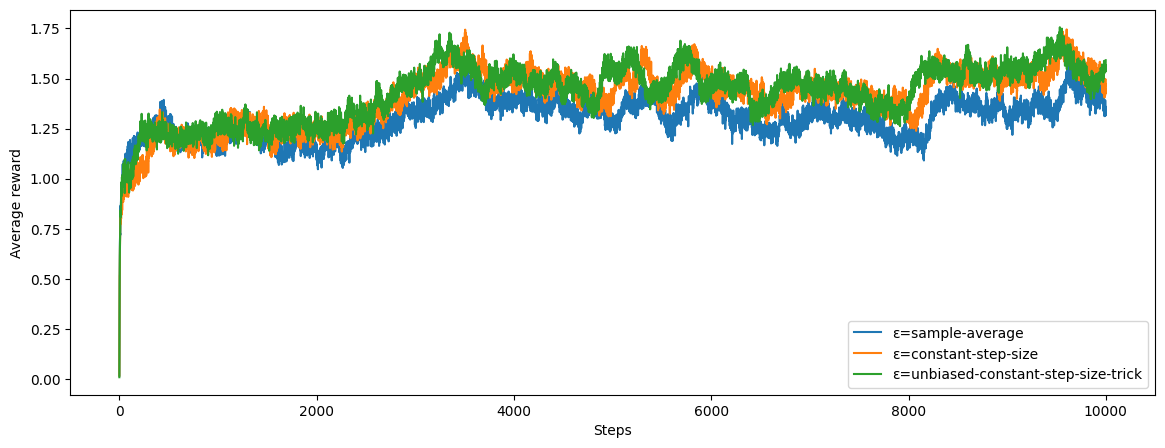

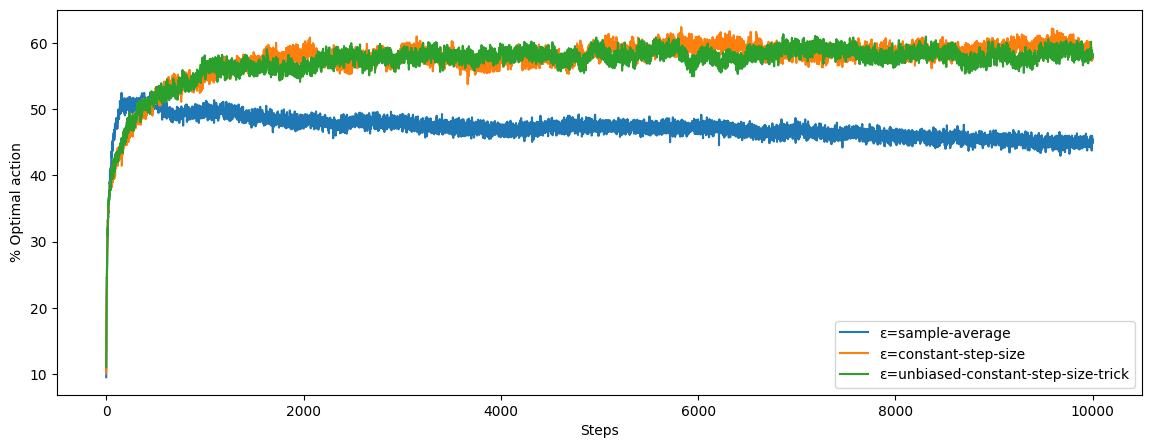

In [7]:
import matplotlib.pyplot as plt
import asyncio
import concurrent.futures
from bandit_problem import  process_bandit_problem_nonstationary
from functools import partial

async def main():
    loop = asyncio.get_running_loop()

    with concurrent.futures.ProcessPoolExecutor() as pool:
        tasks = [
            loop.run_in_executor(pool, partial(process_bandit_problem_nonstationary, num_steps=10000, av_method=avm)) for avm in 
            ['sample-average', 'constant-step-size', 'unbiased-constant-step-size-trick']
        ]
        # Wait for all of them to finish
        results = await asyncio.gather(*tasks)

    # Plot average reward
    plt.figure(figsize=(14, 5))
    for result in results:
        plt.plot(result[1], label=f"ε={result[0]}")
    plt.xlabel("Steps")
    plt.ylabel("Average reward")
    plt.legend()
    plt.show()

    # Plot % optimal action
    plt.figure(figsize=(14, 5))
    for result in results:
        plt.plot(result[2], label=f"ε={result[0]}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal action")
    plt.legend()
    plt.show()

# ✅ Works in Jupyter:
await main()